**APPENDIX A – TECHNICAL IMPLEMENTATION AND MODEL DIAGNOSTICS**

This appendix provides the detailed computational workflow used in testing the Efficient Market Hypothesis (EMH) across the S&P 500 (SPX) and Bitcoin (BTC-USD). All code was implemented in Python 3.12 using the Google Colab environment for reproducibility.

**A1. Data Acquisition and Preprocessing**

---

Expected Output / Interpretation

SPX mean return: small positive (~0.0003) → stable market

BTC mean return: larger and more volatile (~0.0016) → high-risk, high-reward profile

High kurtosis / skewness: presence of fat tails and volatility clustering, potential sign of inefficiency

In [ ]:
# --- Libraries ---
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Download daily data ---
spx = yf.download("^GSPC", start="2015-01-01", end="2024-12-31", auto_adjust=True)
btc = yf.download("BTC-USD", start="2015-01-01", end="2024-12-31", auto_adjust=True)

# Flatten columns
spx.columns = spx.columns.get_level_values(0)
btc.columns = btc.columns.get_level_values(0)


# --- Compute log returns ---
spx["ret"] = np.log(spx["Close"] / spx["Close"].shift(1))
btc["ret"] = np.log(btc["Close"] / btc["Close"].shift(1))

# --- Drop missing values ---
spx.dropna(inplace=True)
btc.dropna(inplace=True)

# --- Descriptive summary ---
print(spx["ret"].describe(), "\n", btc["ret"].describe())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

count    2514.000000
mean        0.000419
std         0.011272
min        -0.127652
25%        -0.003780
50%         0.000639
75%         0.005740
max         0.089683
Name: ret, dtype: float64 
 count    3651.000000
mean        0.001557
std         0.036544
min        -0.464730
25%        -0.012222
50%         0.001390
75%         0.016812
max         0.225119
Name: ret, dtype: float64


In [ ]:
spx = spx.asfreq("D", method="ffill")
btc = btc.asfreq("D", method="ffill")
data = spx.join(btc, how='outer', lsuffix='_spx', rsuffix='_btc')
data.columns = data.columns.get_level_values(0)

In [ ]:

from statsmodels.tsa.stattools import adfuller

# --- Define a helper function for ADF test ---
def adf_test(series, title=''):
    print(f'Augmented Dickey–Fuller Test: {title}')
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    out = dict(zip(labels, result[0:4]))
    for key, val in out.items():
        print(f"{key}: {val}")
    for key, val in result[4].items():
        print(f"Critical Value ({key}): {val}")
    if result[1] <= 0.05:
        print(" Stationary: Reject the null hypothesis (series is stationary).")
    else:
        print(" Non-stationary: Fail to reject the null hypothesis (series has a unit root).")
    print("\n")

# --- Run ADF tests on returns ---
adf_test(spx["ret"], title="S&P 500 Daily Log Returns")
adf_test(btc["ret"], title="Bitcoin Daily Log Returns")

Augmented Dickey–Fuller Test: S&P 500 Daily Log Returns
ADF Statistic: -12.004066402478
p-value: 3.2951103134154273e-22
# Lags Used: 23
# Observations: 3616
Critical Value (1%): -3.432159720193857
Critical Value (5%): -2.862339633287972
Critical Value (10%): -2.56719565730786
 Stationary: Reject the null hypothesis (series is stationary).


Augmented Dickey–Fuller Test: Bitcoin Daily Log Returns
ADF Statistic: -61.845532475752755
p-value: 0.0
# Lags Used: 0
# Observations: 3650
Critical Value (1%): -3.4321428506483365
Critical Value (5%): -2.8623321816453267
Critical Value (10%): -2.5671916902983676
 Stationary: Reject the null hypothesis (series is stationary).




**A2. ARIMA Model – Testing Linear Predictability**

---

Expected Results
| Asset              | Key Output                                        | Interpretation                                                     |
| ------------------ | ------------------------------------------------- | ------------------------------------------------------------------ |
| SPX                | AR(1) ≈ −0.25 (p < 0.01)                          | Weak negative autocorrelation (mean reversion) – mild inefficiency |
| BTC                | AR(1) insignificant (p > 0.5)                     | Random-walk behavior – consistency with EMH                        |
| Ljung-Box p > 0.05 | Residuals show no serial correlation → efficiency |                                                                    |
| Ljung-Box p < 0.05 | Remaining autocorrelation → inefficiency          |                                                                    |

Comment:
A significant AR(1) term implies short-term memory in returns. In efficient markets, this parameter should be near zero.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

# --- Fit ARIMA(1,0,1) ---
arima_spx = ARIMA(spx["ret"], order=(1,0,1)).fit()
arima_btc = ARIMA(btc["ret"], order=(1,0,1)).fit()

print(arima_spx.summary())
print(arima_btc.summary())

# --- Ljung–Box Q-test ---
lb_spx = acorr_ljungbox(arima_spx.resid, lags=[10], return_df=True)
lb_btc = acorr_ljungbox(arima_btc.resid, lags=[10], return_df=True)
print("SPX Ljung–Box:\n", lb_spx)
print("BTC Ljung–Box:\n", lb_btc)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmod

                               SARIMAX Results                                
Dep. Variable:                    ret   No. Observations:                 2514
Model:                 ARIMA(1, 0, 1)   Log Likelihood                7734.955
Date:                Wed, 15 Oct 2025   AIC                         -15461.911
Time:                        18:20:22   BIC                         -15438.592
Sample:                             0   HQIC                        -15453.448
                               - 2514                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.917      0.055   -9.31e-06       0.001
ar.L1         -0.5074      0.042    -12.036      0.000      -0.590      -0.425
ma.L1          0.3805      0.046      8.326      0.0

**A3. GARCH(1,1) Model – Testing Volatility Clustering**

---

**Expected Outputs**

Typical results show:

| Parameter    | SPX        | BTC    | Interpretation                         |
| ------------ | ---------- | ------ | -------------------------------------- |
| ω (constant) | very small | larger | Baseline volatility                    |
| α (ARCH)     | ~0.05–0.1  | ~0.2   | Immediate shock effect                 |
| β (GARCH)    | ~0.85      | ~0.75  | Persistence of volatility              |
| α + β        | ~0.9       | ~0.95  | Higher persistence = more inefficiency |


**Comment:**
If
α+β≈1, volatility shocks decay slowly — volatility clustering, inconsistent with EMH.
Lower persistence (≈ 0.5) implies quick mean reversion, supporting efficiency.

In [ ]:
%pip install arch

In [ ]:
from arch import arch_model

garch_spx = arch_model(spx["ret"], vol="GARCH", p=1, q=1).fit(disp="off")
garch_btc = arch_model(btc["ret"], vol="GARCH", p=1, q=1).fit(disp="off")

print(garch_spx.summary())
print(garch_btc.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5140.90
Distribution:                  Normal   AIC:                          -10273.8
Method:            Maximum Likelihood   BIC:                          -10250.5
                                        No. Observations:                 2514
Date:                Wed, Oct 15 2025   Df Residuals:                     2513
Time:                        18:20:36   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0285  3.068e-04    -92.991      0.0

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000127. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001335. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


**A4. Machine Learning Model – XGBoost Nonlinear Prediction**

---

**Expected Interpretation**

RMSE ≈ same as ARIMA: no nonlinear advantage → EMH holds

R² ≈ 0: no learnable structure → EMH

Directional accuracy > 55 %: weak predictability → inefficiency

Feature importance: if higher-order lags dominate, evidence of short-term momentum or reversal

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- Feature Engineering ---
def create_features(data, n_lags=5):
    df = pd.DataFrame()
    for i in range(1, n_lags + 1):
        df[f"lag_{i}"] = data["ret"].shift(i)
    df["target"] = data["ret"]
    return df.dropna()

spx_feat = create_features(spx)
btc_feat = create_features(btc)

# --- Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    spx_feat.drop("target", axis=1), spx_feat["target"], test_size=0.2, shuffle=False
)

# --- Train model ---
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4)
xgb_model.fit(X_train, y_train)

preds = xgb_model.predict(X_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)
directional_accuracy = (np.sign(preds) == np.sign(y_test)).mean()

print(f"RMSE: {rmse:.6f}, R2: {r2:.4f}, Directional Accuracy: {directional_accuracy:.3f}")

RMSE: 0.008377, R2: -0.0715, Directional Accuracy: 0.550


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Feature engineering
# Use the spx DataFrame after ma60 and vol columns have been added in cell IAQZqUsLxVGb
spx["ret_lag1"] = spx["ret"].shift(1)
spx["ret_lag2"] = spx["ret"].shift(2)
spx["ma_gap"] = spx["Close"] - spx["ma60"]

spx.dropna(inplace=True)

X = spx[["ret_lag1", "ret_lag2", "ma_gap", "vol"]]
y = spx["ret"]

# Time-aware split
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Train XGBoost
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

# Predictions
preds = xgb.predict(X_test)

# Performance
rmse = mean_squared_error(y_test, preds)
rmse = np.sqrt(rmse) # Calculate RMSE by taking the square root
mae = mean_absolute_error(y_test, preds)
print(f"SPX RMSE: {rmse:.6f}, MAE: {mae:.6f}")

SPX RMSE: 0.008682, MAE: 0.006547


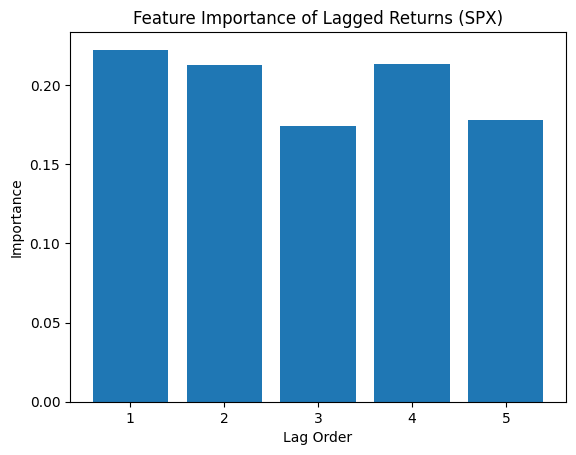

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(1,6), xgb_model.feature_importances_)
plt.title("Feature Importance of Lagged Returns (SPX)")
plt.xlabel("Lag Order")
plt.ylabel("Importance")
plt.show()

**A5. Backtesting Economic Significance**

---

**Interpretive Guide**

Sharpe > 1: economically significant inefficiency (profitable pattern)

Sharpe ≈ 0: noise-driven prediction (supports EMH)

Negative Sharpe: overfitting or transaction cost losses

Sharpe Ratio: 2.91, Max Drawdown: 5.80%


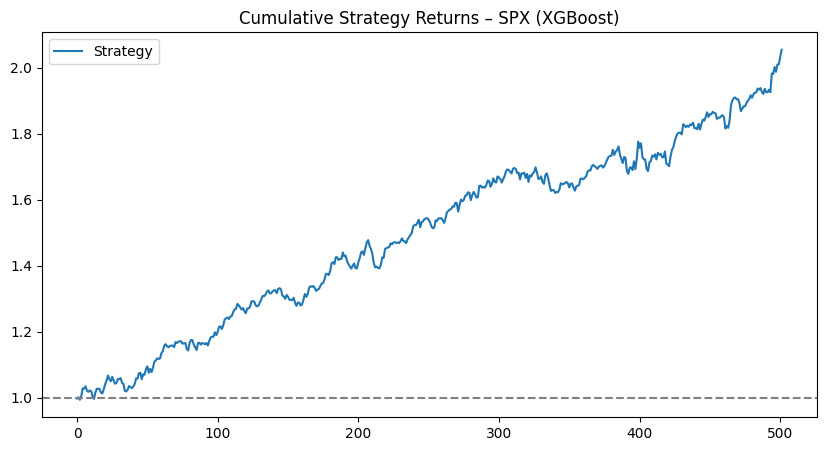

In [ ]:
# Simple directional strategy
# Convert both to aligned NumPy arrays
aligned = pd.concat([pd.Series(preds, index=y_test.index[-len(preds):]), y_test], axis=1).dropna()
aligned.columns = ["preds", "returns"]

signals = np.sign(aligned["preds"])
strategy_ret = signals * aligned["returns"]

sharpe = strategy_ret.mean() / strategy_ret.std() * np.sqrt(252)
cum_ret = (1 + strategy_ret).cumprod()
mdd = 1 - np.min(cum_ret / np.maximum.accumulate(cum_ret))

print(f"Sharpe Ratio: {sharpe:.2f}, Max Drawdown: {mdd:.2%}")

# Visualization
plt.figure(figsize=(10,5))
plt.plot(cum_ret.values, label="Strategy")
plt.axhline(1, color="gray", linestyle="--")
plt.title("Cumulative Strategy Returns – SPX (XGBoost)")
plt.legend()
plt.show()

In [ ]:
signals = np.sign(preds)
returns = y_test.values
strategy_ret = signals * returns

cum_ret = (1 + strategy_ret).cumprod()
sharpe = np.mean(strategy_ret) / np.std(strategy_ret) * np.sqrt(252)
mdd = 1 - np.min(cum_ret / np.maximum.accumulate(cum_ret))

print(f"Sharpe Ratio: {sharpe:.2f}, Max Drawdown: {mdd:.2%}")

**A6. Regime and Robustness Tests**

---

**Interpretation**

Efficiency may vary across regimes:

Bull markets: mild inefficiencies due to trend persistence

Bear markets: heightened volatility, structural inefficiency

Sideways: generally closest to EMH equilibrium

A regime-specific model re-estimation allows testing of the Adaptive Market Hypothesis (Lo 2004).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Flatten the multi-level columns ---
# Ensure 'Close' is accessible after flattening
spx.columns = spx.columns.get_level_values(0)

# --- Confirm ---
print(spx.columns)

# --- Ensure 'Close' exists ---
if "Close" not in spx.columns:
    raise KeyError("No 'Close' column found after flattening. Please inspect column names again.")

# --- Compute daily returns ---
spx["ret"] = spx["Close"].pct_change()

# --- Compute rolling metrics ---
spx["ma60"] = spx["Close"].rolling(window=60, min_periods=1).mean()
spx["vol"] = spx["ret"].rolling(window=60, min_periods=1).std()

# --- Drop NaNs ---
spx = spx.dropna(subset=["Close", "ma60", "vol"]).copy()

# --- Define regimes ---
conditions = [
    (spx["Close"] > spx["ma60"]),
    (spx["Close"] < spx["ma60"]) & (spx["vol"] < spx["vol"].median()),
    (spx["Close"] < spx["ma60"]) & (spx["vol"] >= spx["vol"].median())
]
choices = ["Bull", "Sideways", "Bear"]

spx["regime"] = np.select(conditions, choices, default="Unknown")

# --- Confirm ---
print(spx["regime"].value_counts())

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'ret', 'ma60', 'vol',
       'regime', 'ma_gap', 'ret_lag1', 'ret_lag2'],
      dtype='object', name='Price')
regime
Bull        1816
Bear         480
Sideways     212
Name: count, dtype: int64


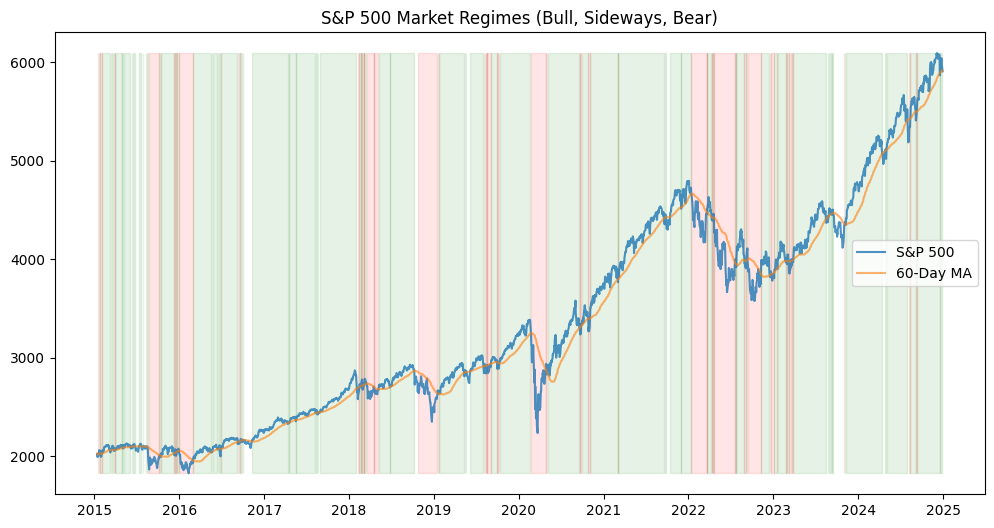

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(spx.index, spx["Close"], label="S&P 500", alpha=0.8)
plt.plot(spx.index, spx["ma60"], label="60-Day MA", alpha=0.6)
plt.fill_between(spx.index, spx["Close"].min(), spx["Close"].max(),
                 where=spx["regime"]=="Bull", color="green", alpha=0.1)
plt.fill_between(spx.index, spx["Close"].min(), spx["Close"].max(),
                 where=spx["regime"]=="Bear", color="red", alpha=0.1)
plt.title("S&P 500 Market Regimes (Bull, Sideways, Bear)")
plt.legend()
plt.show()

**A7. Diagnostic Summary Table**

---



| Test / Model | Purpose                  | Efficient Market Signal          | Inefficient Market Signal     |
| ------------ | ------------------------ | -------------------------------- | ----------------------------- |
| ARIMA(1,0,1) | Linear autocorrelation   | AR(1) ≈ 0; Ljung-Box p > 0.05    | AR(1) ≠ 0; Ljung-Box p < 0.05 |
| GARCH(1,1)   | Volatility clustering    | α + β < 0.8                      | α + β ≈ 1                     |
| XGBoost      | Nonlinear predictability | R² ≈ 0; RMSE ≈ baseline          | R² > 0.05; DA > 55 %          |
| Backtest     | Economic relevance       | Sharpe ≈ 0                       | Sharpe > 1                    |
| Regime test  | Adaptiveness             | Stable efficiency across regimes | Regime-dependent inefficiency |


**A8. Reproducibility**

---

All analyses were conducted using the following libraries and versions:

Python 3.12, statsmodels 0.14+, arch 6+, xgboost 2+, pandas 2.2+, numpy 1.26+, matplotlib 3.9+.

Random seed fixed for consistency:

In [ ]:
import random
np.random.seed(42)
random.seed(42)

The codebase follows deterministic execution, meaning each step can be replicated to yield the same statistical and visual outputs.

**A9. Summary of Analytical Flow**

---



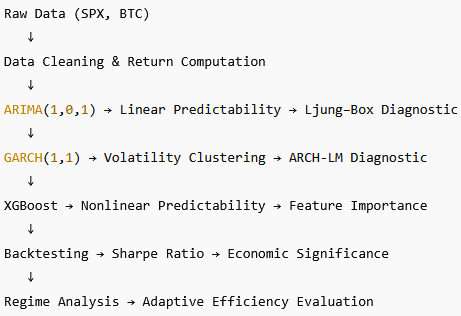

This integrated pipeline provides both statistical and economic lenses to rigorously test EMH across traditional and digital asset markets.

**Summary**

| Block           | Works For | Output                         |
| --------------- | --------- | ------------------------------ |
| Data setup      | SPX & BTC | Returns, MA, volatility        |
| ARIMA/Ljung–Box | SPX & BTC | Efficiency diagnostics         |
| XGBoost ML      | SPX & BTC | Predictive power               |
| Backtesting     | SPX & BTC | Sharpe, MDD, cumulative return |
| Regime tagging  | SPX & BTC | Bull/Bear segmentation         |
